<a href="https://colab.research.google.com/github/miraclehimself/Advanced_ML/blob/main/Interactions_week4c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML 22-23 S2W4 Webinar: Interactions

## Packages

In [ ]:
!pip install --upgrade scikit-learn matplotlib pandas seaborn -q --user
!pip install -q shap
# need to restart kernel, if latest versions not already installed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks',
    context='talk',
    font_scale=0.8,
    rc={'figure.figsize': (8,6)}
)

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
from sklearn.metrics import mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
import shap
shap.initjs()

## Dataset

In [ ]:
rides_full = pd.read_csv(
    'https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv'
)

In [ ]:
rides_full.shape

(731, 12)

In [ ]:
rides_full.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


In [ ]:
rides_full.tail(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
730,WINTER,2012,DEC,NO HOLIDAY,MON,WORKING DAY,MISTY,2.144151,57.75,10.374682,2729,730


In [ ]:
rides_full.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


In [ ]:
rides_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [ ]:
rides = rides_full[
    [ 'workingday', 'temp', 'hum', 'windspeed', 'days_since_2011', 'cnt' ]
].rename(columns=dict(days_since_2011='days_elapsed', cnt='rides_count'))

In [ ]:
rides.head()

,workingday,temp,hum,windspeed,days_elapsed,rides_count
0,NO WORKING DAY,8.175849,80.5833,10.749882,0,985
1,NO WORKING DAY,9.083466,69.6087,16.652113,1,801
2,WORKING DAY,1.229108,43.7273,16.636703,2,1349
3,WORKING DAY,1.400000,59.0435,10.739832,3,1562
4,WORKING DAY,2.666979,43.6957,12.522300,4,1600


In [ ]:
X, y = rides.drop(columns='rides_count'), rides['rides_count']
# X, y = rides, rides['rides_count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

## Pre-Processing and Model Fitting Pipelines

In [ ]:
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("poly_int", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]
).set_output(transform='pandas')
print(numeric_features)
numeric_transformer

['temp', 'hum', 'windspeed', 'days_elapsed']


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('poly_int', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler())])

In [ ]:
numeric_transformer.fit_transform(X_train[numeric_features]).head()

,temp,hum,windspeed,days_elapsed,temp^2,temp hum,temp windspeed,temp days_elapsed,hum^2,hum windspeed,hum days_elapsed,windspeed^2,windspeed days_elapsed,days_elapsed^2
452,-0.039260,-1.008306,1.313328,0.414193,-0.314851,-0.421981,0.843963,0.199714,-0.989096,0.485717,-0.063230,1.261576,1.301250,0.166135
337,-0.873856,1.115157,-1.373436,-0.127700,-0.912507,-0.634612,-1.160919,-0.680878,1.122668,-0.991333,0.243236,-1.030593,-0.772360,-0.398485
509,0.890583,0.688667,-0.223027,0.682784,0.805842,1.154845,0.644888,1.251563,0.619098,0.162584,0.964062,-0.359478,0.423447,0.506999
77,-0.102764,-1.744159,2.302804,-1.352851,-0.373901,-0.714899,1.350302,-0.990395,-1.489979,0.470601,-1.377035,2.744436,-0.771261,-1.068301
451,-0.914679,-2.386907,-0.038108,0.409481,-0.931833,-1.278781,-0.771232,-0.531119,-1.830241,-1.204401,-0.668303,-0.208245,0.351742,0.160516


In [ ]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
    ]
).set_output(transform='pandas')
print(categorical_features)
categorical_transformer

['workingday']


Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

In [ ]:
X_train['workingday'].head()

452       WORKING DAY
337    NO WORKING DAY
509       WORKING DAY
77     NO WORKING DAY
451       WORKING DAY
Name: workingday, dtype: object

In [ ]:
categorical_transformer.fit_transform(X_train[categorical_features]).head()

,workingday_WORKING DAY
452,1.0
337,0.0
509,1.0
77,0.0
451,1.0


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [ ]:
preprocessor.fit_transform(X_train).head()

,temp,hum,windspeed,days_elapsed,temp^2,temp hum,temp windspeed,temp days_elapsed,hum^2,hum windspeed,hum days_elapsed,windspeed^2,windspeed days_elapsed,days_elapsed^2,workingday_WORKING DAY
452,-0.039260,-1.008306,1.313328,0.414193,-0.314851,-0.421981,0.843963,0.199714,-0.989096,0.485717,-0.063230,1.261576,1.301250,0.166135,1.0
337,-0.873856,1.115157,-1.373436,-0.127700,-0.912507,-0.634612,-1.160919,-0.680878,1.122668,-0.991333,0.243236,-1.030593,-0.772360,-0.398485,0.0
509,0.890583,0.688667,-0.223027,0.682784,0.805842,1.154845,0.644888,1.251563,0.619098,0.162584,0.964062,-0.359478,0.423447,0.506999,1.0
77,-0.102764,-1.744159,2.302804,-1.352851,-0.373901,-0.714899,1.350302,-0.990395,-1.489979,0.470601,-1.377035,2.744436,-0.771261,-1.068301,0.0
451,-0.914679,-2.386907,-0.038108,0.409481,-0.931833,-1.278781,-0.771232,-0.531119,-1.830241,-1.204401,-0.668303,-0.208245,0.351742,0.160516,1.0


In [ ]:
regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regr", Ridge(alpha=10))
    ]
).set_output(transform="pandas")

In [ ]:
regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly_int',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_elapsed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workingday'])],
                                   verbose_feature_names_out=False)),
                ('regr', Ridge(alpha=10))])

## Evaluation of Linear Model

In [ ]:
regr_pipe.score(X_test, y_test)

0.7940512569104817

In [ ]:
rmse(y_test, regr_pipe.predict(X_test))

955.5472115010942

In [ ]:
y_test.describe()

count     183.000000
mean     4504.808743
std      2111.360670
min       605.000000
25%      2913.500000
50%      4548.000000
75%      6230.000000
max      8714.000000
Name: rides_count, dtype: float64

In [ ]:
rmse(y_test, DummyRegressor().fit(X_train, y_train).predict(X_test))

2105.5841124358044

In [ ]:
def get_feat_coef_lm(regr_pipe):
    return pd.DataFrame(
        zip(
            regr_pipe['regr'].coef_,
            regr_pipe['regr'].feature_names_in_
        ),
        columns=['coef', 'feat']
    ).sort_values(by='coef', key=np.abs, ascending=False)

get_feat_coef_lm(regr_pipe)

,coef,feat
4,-1254.537337,temp^2
0,1081.202162,temp
3,731.809194,days_elapsed
7,707.156910,temp days_elapsed
5,542.366543,temp hum
8,-438.077756,hum^2
9,-425.534272,hum windspeed
10,-328.648188,hum days_elapsed
6,322.429767,temp windspeed
11,-269.072078,windspeed^2


## Grid Search


In [ ]:
param_grid = dict(
    regr__alpha=np.logspace(-3, 3, 7)
)

In [ ]:
grid = GridSearchCV(
    regr_pipe, param_grid, return_train_score=True,
    scoring='neg_root_mean_squared_error'
)

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('poly_int',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'hum',
                                                                          'windspeed',
                                                                          'days_elapsed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['workingday'])],
                                                          verbose_feature_names_out=False)),
                                       ('regr', Ridge(alpha=10))]),
             param_grid={'regr__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
results = pd.DataFrame(grid.cv_results_)

In [ ]:
results[
    [ 'param_regr__alpha', 'mean_test_score', 'std_test_score',
      'mean_train_score', 'std_train_score', 'rank_test_score' ]
].sort_values('rank_test_score').rename(
    columns=dict(
        param_regr__alpha='alpha'
    )
)

,alpha,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score
0,0.001,-793.122624,64.888291,-739.964377,12.611904,1
1,0.01,-793.130810,65.018436,-739.965052,12.611978,2
2,0.1,-793.258304,66.258447,-740.028334,12.618849,3
3,1.0,-796.955529,74.586935,-743.782207,12.983591,4
4,10.0,-838.345092,96.182561,-792.246239,15.843484,5
5,100.0,-944.093916,125.052173,-913.746016,24.284530,6
6,1000.0,-1138.386488,121.800437,-1124.161914,29.951508,7


## Cross Validation

In [ ]:
scores = cross_val_score(
    regr_pipe, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'
)*-1
scores.mean(), scores.std()

(818.1238745094179, 90.324465282668)

## SHAP

In [ ]:
X_pp = regr_pipe['preprocessor'].transform(X_test)

In [ ]:
X100 = shap.utils.sample(X_pp, 100) # 100 instances for use as the background distribution

In [ ]:
explainer = shap.Explainer(regr_pipe['regr'].predict, X100)
shap_values = explainer(X_pp)

Permutation explainer: 184it [00:12,  2.81it/s]                         


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


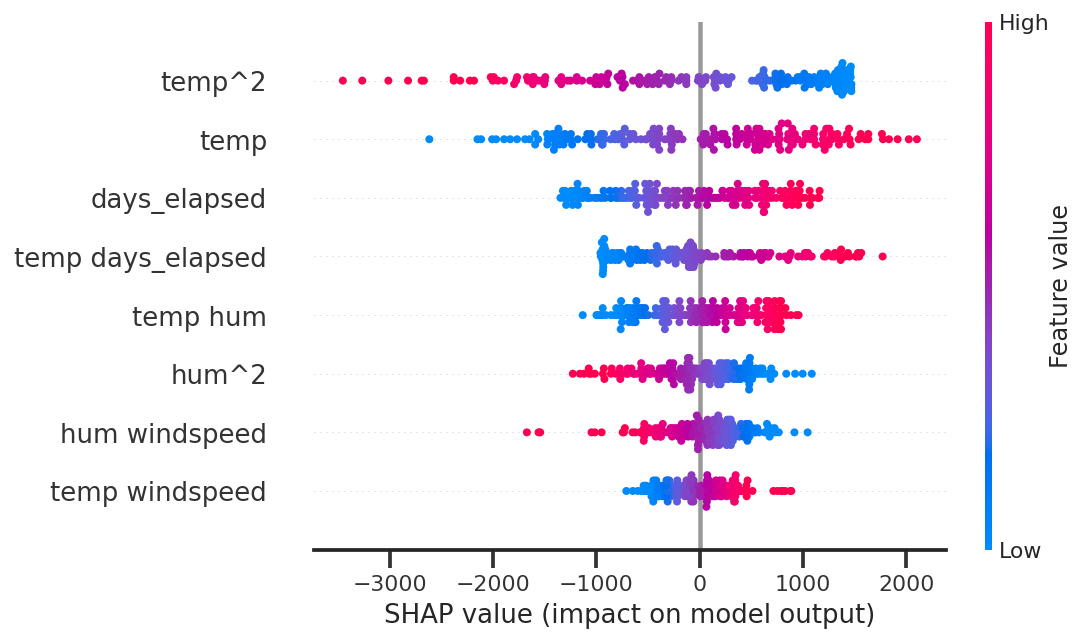

In [ ]:
shap.summary_plot(shap_values, X_pp, max_display=8)

## Actual vs Predicted

In [ ]:
def plot_true_vs_predicted(
        est,
        X_train, y_train,
        X_test, y_test,
        ax=None,
        train_style_kws={},
        test_style_kws={}
    ):
    if ax is None:
        fig, ax = plt.subplots()
    y_pred_train = est.predict(X_train)
    y_pred_test = est.predict(X_test)
    ax.plot(y_train, y_pred_train, '.', label='train', **train_style_kws)
    ax.plot(y_test, y_pred_test, '.', label='test', **test_style_kws)
    ax.set_xlabel('True Target')
    ax.set_ylabel('Predicted Target')
    # the diagnonal line for the idealised space of predictions
    ax.plot(
        [0, 1], [0, 1], transform=ax.transAxes,
        color='gray', linestyle=':', alpha=0.3
    )
    ax.legend()

    return ax

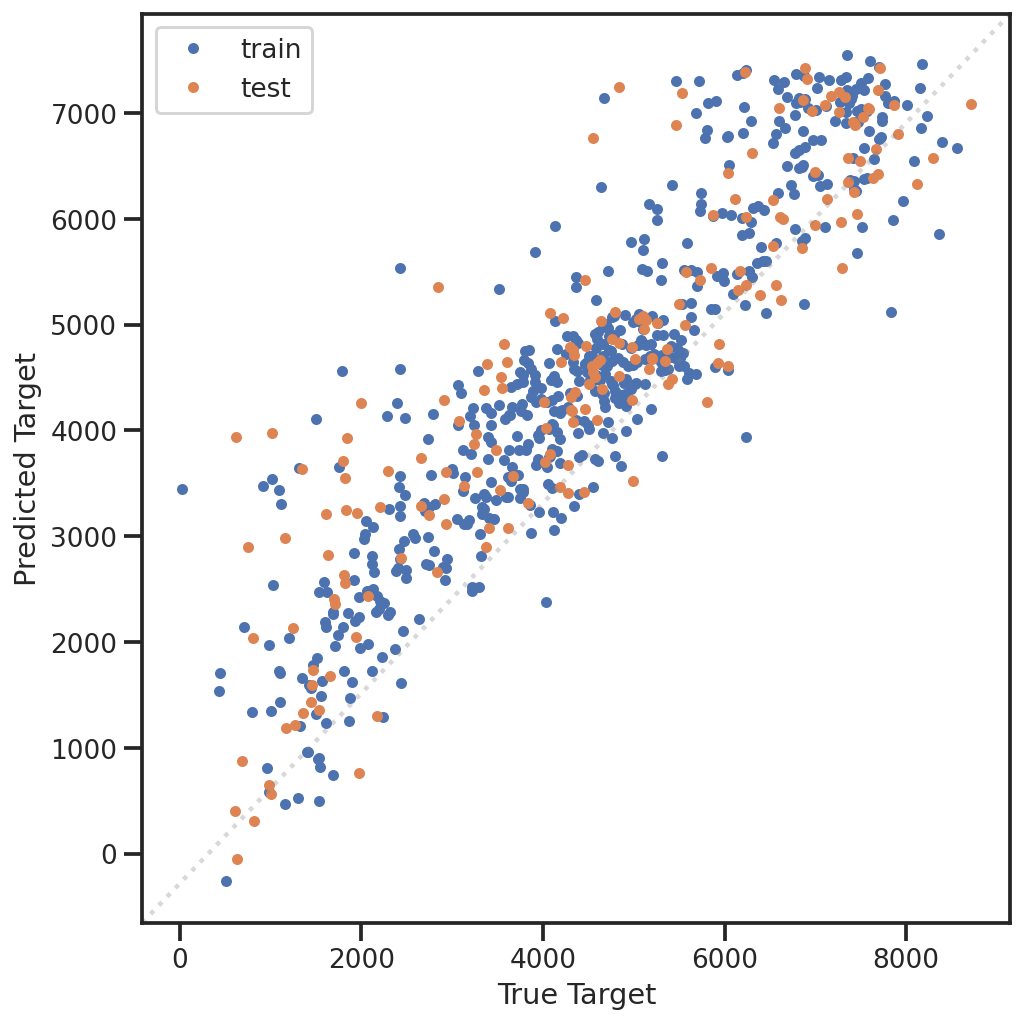

In [ ]:
fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)
plot_true_vs_predicted(
    regr_pipe,
    X_train, y_train,
    X_test, y_test,
    ax=ax
);

## Remember Tree Ensembles?

In [ ]:
regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regr", RandomForestRegressor(
              max_depth=8, min_samples_split=15,
              min_samples_leaf=8, n_estimators=400
        ))
    ]
).set_output(transform="pandas")

In [ ]:
regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly_int',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_elapsed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workingday'])],
                                   verbose_feature_names_out=False)),
                ('regr',
                 RandomForestRegressor(max_depth=8, min_samples_leaf=8,
                                       min_samples_split=15,
                                       n_estimators=400))])

In [ ]:
regr_pipe.score(X_test, y_test)

0.8478675202416118

In [ ]:
rmse(y_test, regr_pipe.predict(X_test))

821.2654423401017

In [ ]:
scores = cross_val_score(
    regr_pipe, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'
)*-1
scores.mean(), scores.std()

(747.7079581941459, 175.20009113162587)

In [ ]:
regr_pipe['preprocessor'].get_feature_names_out()

array(['temp', 'hum', 'windspeed', 'days_elapsed', 'temp^2', 'temp hum',
       'temp windspeed', 'temp days_elapsed', 'hum^2', 'hum windspeed',
       'hum days_elapsed', 'windspeed^2', 'windspeed days_elapsed',
       'days_elapsed^2', 'workingday_WORKING DAY'], dtype=object)

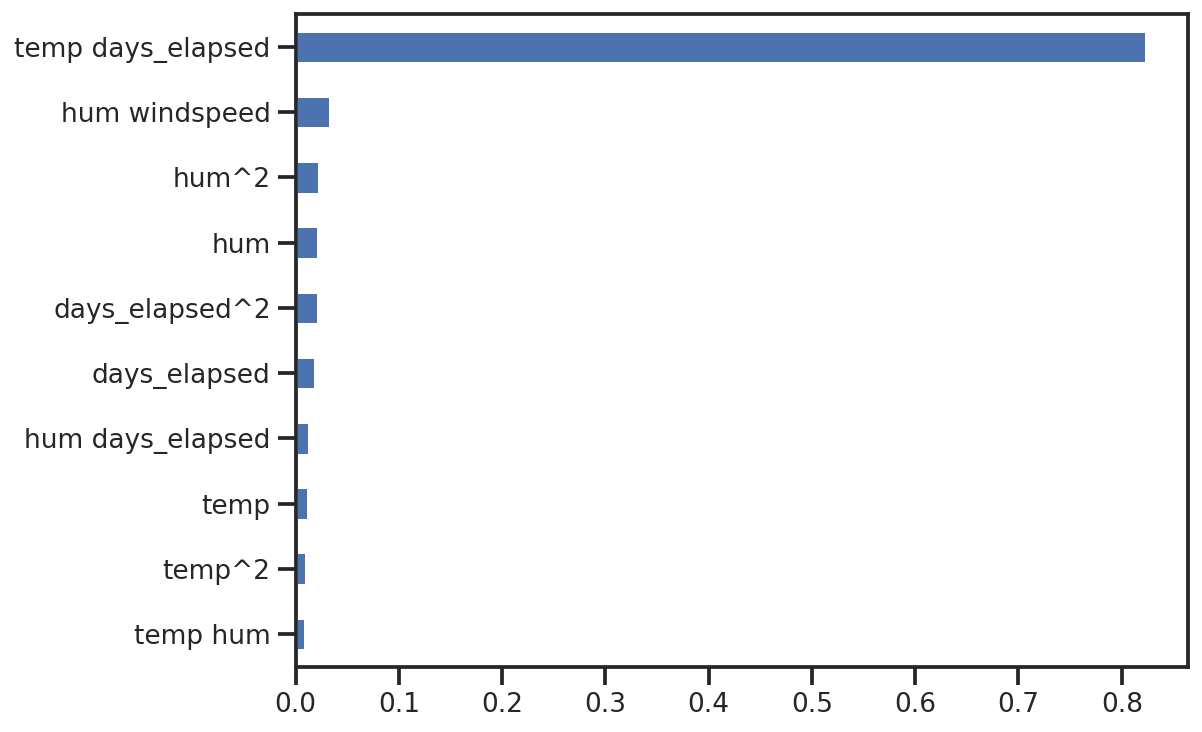

In [ ]:
def plot_rf_feat_imp_barh(rf, feat_names, ax=None, top_feat_k=10, style_kws={}):
    """ """
    if ax is None:
        fig, ax = plt.subplots()

    return pd.Series(
        rf.feature_importances_,
        index=feat_names
    ).sort_values().tail(top_feat_k).plot.barh(**style_kws)

plot_rf_feat_imp_barh(
    regr_pipe['regr'],
    regr_pipe['preprocessor'].get_feature_names_out()
);

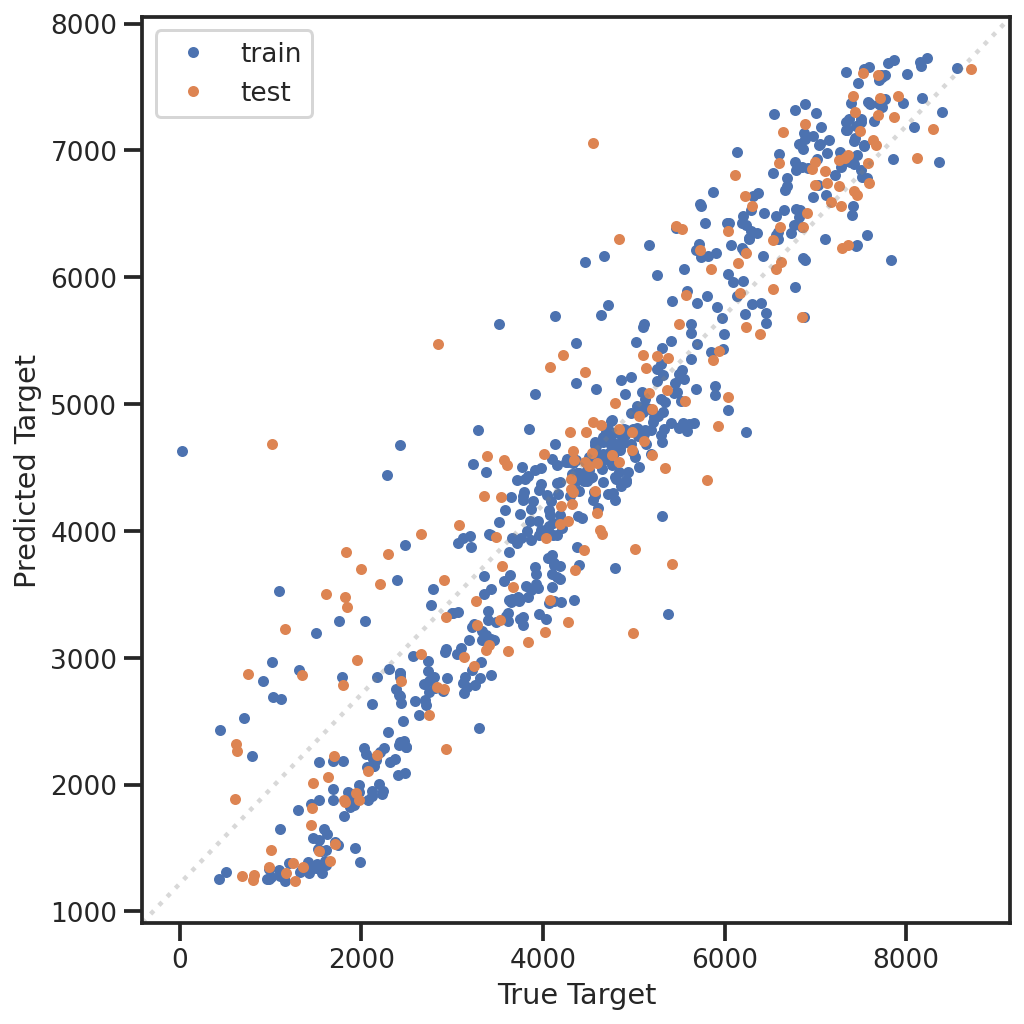

In [ ]:
fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)
plot_true_vs_predicted(
    regr_pipe,
    X_train, y_train,
    X_test, y_test,
    ax=ax
);

In [ ]:
# Message: we'll see if we can improve the linear model's performance by removing
# unimportant features; the tree ensemble would be doing this by default

## OLS and Significant Coefficients

In [ ]:
import statsmodels.api as sm
ols = sm.OLS(y_train, preprocessor.fit_transform(X_train))
# ols = sm.OLS(y_train, X_train[numeric_features])
ols = ols.fit()
ols.summary2().tables[1]['P>|t|']

temp                       1.974180e-02
hum                        1.760815e-01
windspeed                  1.705637e-01
days_elapsed               1.796032e-01
temp^2                     5.536274e-06
temp hum                   1.829446e-01
temp windspeed             7.280288e-01
temp days_elapsed          8.688872e-03
hum^2                      1.153818e-01
hum windspeed              1.162288e-01
hum days_elapsed           1.144386e-01
windspeed^2                1.319520e-01
windspeed days_elapsed     6.944807e-01
days_elapsed^2             8.234793e-01
workingday_WORKING DAY    1.045337e-137
Name: P>|t|, dtype: float64

In [ ]:
import statsmodels.api as sm
ols = sm.OLS(y_train, preprocessor.fit_transform(X_train))
ols = ols.fit()
pvalues = ols.summary2().tables[1]['P>|t|'].sort_values()

In [ ]:
high_pvalues = pvalues[ pvalues>0.05 ]
high_pvalues

hum days_elapsed          0.114439
hum^2                     0.115382
hum windspeed             0.116229
windspeed^2               0.131952
windspeed                 0.170564
hum                       0.176081
days_elapsed              0.179603
temp hum                  0.182945
windspeed days_elapsed    0.694481
temp windspeed            0.728029
days_elapsed^2            0.823479
Name: P>|t|, dtype: float64

## SHAP again

In [ ]:
explainer = shap.TreeExplainer(regr_pipe['regr'])
shap_values = explainer.shap_values(X_pp)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


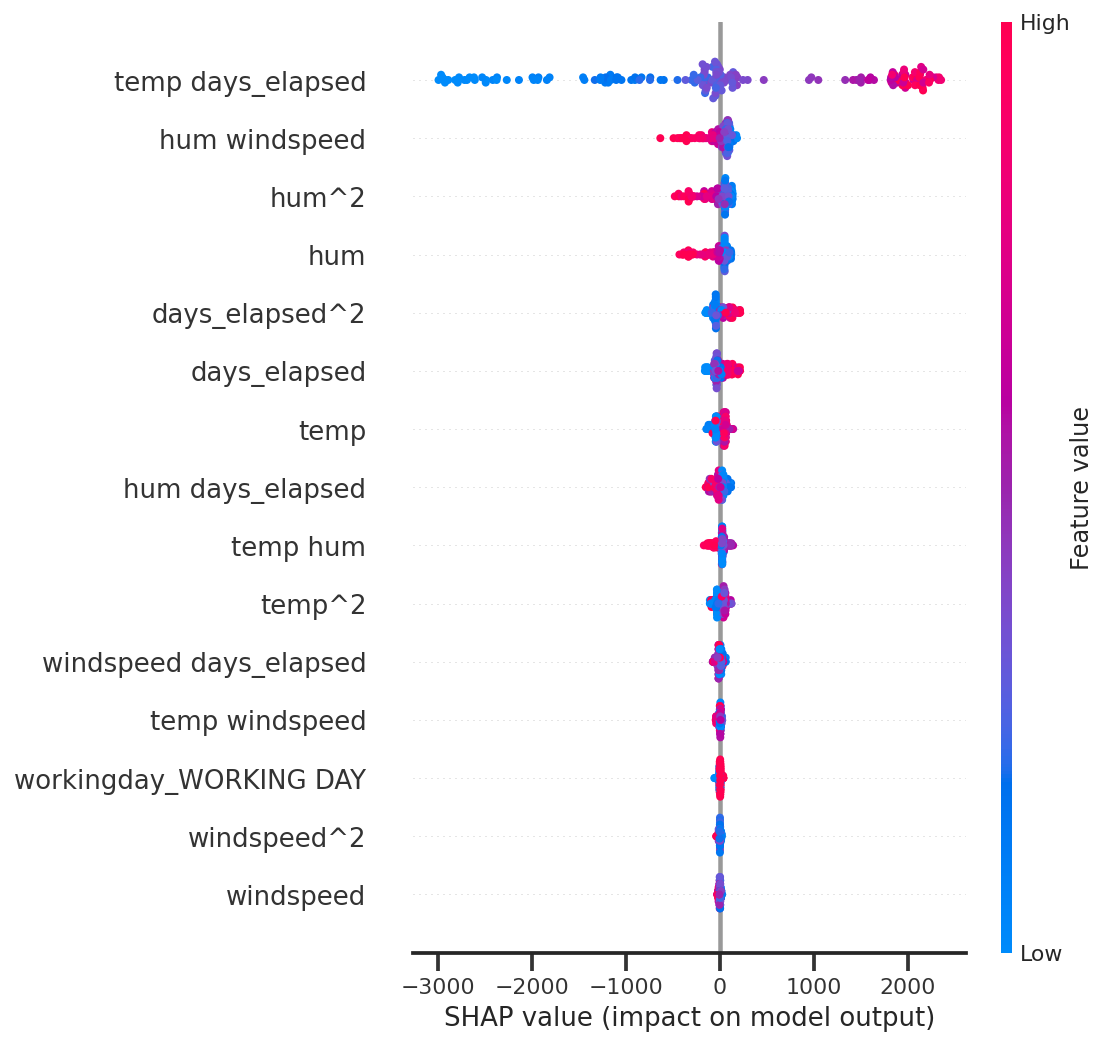

In [ ]:
shap.summary_plot(shap_values, X_pp)